In [2]:
import torch
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
import numpy as np
import time
import os
import shutil

In [3]:
# Estableciendo hiperparametros para que todos trabajen en ingualdad de condiciones
# Hiperparametros
lr=0.000005
num_epochs = 100
batch_size = 50

In [4]:
# Transformaciones para hacer las imagenes aptas para 
#AlexNet  VGG16  ResNet50  DenseNet121  MovileNetV2 
# Todas requieren 244x244 píxeles
transform= transforms.Compose([
    transforms.Resize(256), #reajuste de tamaño
    transforms.CenterCrop (244), # Corte de imagen
    transforms.ToTensor(), # Convierte la imagen a PIL (Python Imaginary Library) a un tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Normalización y estandarización
]
)

In [5]:
#Asignaremos una clase de acuerdo al nombre de la carpeta
#Leemos imagenes
data1= 'C:/Users/Itz/Documents/DOCTORADO/ART-MOBILE-SS/luzAro4C'
# Crear un ImageFolder para los datos
dataset1= ImageFolder(root=data1, transform=transform)
#Selección de imagenes de forma aleatoria,
# obtengo sus indices
indices = {label: np.where(np.array(dataset1.targets) == label)[0] for label in range(len(dataset1.classes))}

# Dividir los índices para cada clase en entrenamiento y prueba
train_indices = []
test_indices = []
for label, idx in indices.items():
    np.random.shuffle(idx)
    train_size = int(0.9 * len(idx))
    train_indices.extend(idx[:train_size])
    test_indices.extend(idx[train_size:])

# Crear subconjuntos de entrenamiento y prueba con los índices obtenidos
train_data1 = Subset(dataset1, train_indices)
test_data1 = Subset(dataset1, test_indices)

# Crear DataLoaders para los conjuntos de entrenamiento y prueba
# cambiar el batch por uno de 50 **asi viene en el articulo**
train_loader = DataLoader(train_data1, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data1, batch_size=batch_size, shuffle=False) # shuffle es falso para no perder la etiqueta de los datos

# Verificar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(train_data1)}")
print(f"Número de muestras de prueba: {len(test_data1)}")

Número de muestras de entrenamiento: 5862
Número de muestras de prueba: 654


In [6]:
# Corroborando las clases detectadas
num_classes = len(dataset1.classes)
print ("El numero de clase es ", +num_classes)
class_names = dataset1.classes # corroborando el numero de clases
print("Las clases son:", class_names) # corroborando el nombre de cada clase

El numero de clase es  4
Las clases son: ['1Fuertemente', '2Contaminada', '3Aceptable', '4Buena']


In [7]:
# Movile Net
# Ruta del directorio de caché
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')

# Prefijo del nombre del archivo de caché para MobileNetV2
mobilenetv2_filename_prefix = 'mobilenet_v2'

# Eliminar solo los archivos de caché de MobileNetV2 si existen
for filename in os.listdir(cache_dir):
    if filename.startswith(mobilenetv2_filename_prefix):
        file_path = os.path.join(cache_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Archivo de caché eliminado: {file_path}")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Directorio de caché eliminado: {file_path}")
    else:
        print(f"No se encontró archivo de caché para MobileNetV2 en: {filename}")

# Descargar modelo preentrenado MobileNetV2
mobilenetv2_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Sustituyendo la capa final por la clasificación propuesta
mobilenetv2_model.classifier[1] = nn.Linear(mobilenetv2_model.classifier[1].in_features, num_classes)


# Mostrar la arquitectura del modelo modificado
#print(mobilenetv2_model)

No se encontró archivo de caché para MobileNetV2 en: alexnet-owt-7be5be79.pth
Archivo de caché eliminado: C:\Users\Itz/.cache/torch/hub/checkpoints\mobilenet_v2-7ebf99e0.pth


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Itz/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 9.25MB/s]


In [8]:
# Calcular metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Función para calcular métricas
def calculate_metrics(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return accuracy, precision, recall, f1, conf_matrix

# Función para acondiconar el tiempo
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours}h {minutes}m {seconds}s"

In [9]:
# # Entrenamiento de MovilNetV2
# Parámetros
num_epochs = num_epochs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Inicialización del modelo MobileNetV2
mobilenetv2_model.to(device)

# Optimizer y Criterion
optimizer_mobilenetv2 = optim.Adam(mobilenetv2_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Historial de métricas
mobilenetv2_train_acc_history = []
mobilenetv2_val_acc_history = []
mobilenetv2_train_loss_history = []
mobilenetv2_val_loss_history = []

# Medir tiempo
start_time_movilnetv2 = time.time()

# Entrenamiento del modelo
for epoch in range(num_epochs):
    mobilenetv2_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    all_preds_train_mobilenetv2 = []
    all_labels_train_mobilenetv2 = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_mobilenetv2.zero_grad()
        outputs = mobilenetv2_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_mobilenetv2.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Collect predictions and labels for training phase metrics
        all_preds_train_mobilenetv2.extend(predicted.cpu().numpy())
        all_labels_train_mobilenetv2.extend(labels.cpu().numpy())

    epoch_loss_mobilenetv2 = running_loss / len(train_loader.dataset)
    epoch_acc_mobilenetv2 = correct_train / total_train
    mobilenetv2_train_loss_history.append(epoch_loss_mobilenetv2)
    mobilenetv2_train_acc_history.append(epoch_acc_mobilenetv2)

    print(f"Epoch [{epoch+1}/{num_epochs}] for MobileNetV2 - Loss: {epoch_loss_mobilenetv2:.4f}, Accuracy: {epoch_acc_mobilenetv2:.4f}")

    # Evaluación en conjunto de validación
    mobilenetv2_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_preds_val_mobilenetv2 = []
    all_labels_val_mobilenetv2 = []
    all_probs_val_mobilenetv2 = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenetv2_model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Probabilidades de cada clase
            _, predicted = torch.max(outputs, 1)
            
            all_probs_val_mobilenetv2.extend(probs.cpu().numpy())
            all_preds_val_mobilenetv2.extend(predicted.cpu().numpy())
            all_labels_val_mobilenetv2.extend(labels.cpu().numpy())
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss_mobilenetv2 = running_val_loss / len(test_loader.dataset)
    epoch_val_acc_mobilenetv2 = correct_val / total_val
    mobilenetv2_val_loss_history.append(epoch_val_loss_mobilenetv2)
    mobilenetv2_val_acc_history.append(epoch_val_acc_mobilenetv2)
    print(f"Validation Loss: {epoch_val_loss_mobilenetv2:.4f}, Validation Accuracy: {epoch_val_acc_mobilenetv2:.4f}")

    # Calcular métricas para fase de validación
    accuracy_val_mobilenetv2, precision_val_mobilenetv2, recall_val_mobilenetv2, f1_val_mobilenetv2, _ = calculate_metrics(all_labels_val_mobilenetv2, all_preds_val_mobilenetv2)
    print(f"MobileNetV2 Validation Metrics: Accuracy: {accuracy_val_mobilenetv2:.4f}, Precision: {precision_val_mobilenetv2:.4f}, Recall: {recall_val_mobilenetv2:.4f}, F1-score: {f1_val_mobilenetv2:.4f}")

end_time_movilnetv2_train = time.time()
# Calcular y mostrar el tiempo de entrenamiento:
movilnetv2_training_time = format_time(end_time_movilnetv2_train - start_time_movilnetv2)

print(f"El tiempo de entrenamiento de MovilNetV2 es de: {movilnetv2_training_time}")

movilnetv2_training_time = end_time_movilnetv2_train - start_time_movilnetv2
#Guadrar Metricas 
movilnetv2_val_metricsM1 = {
    "Accuracy": accuracy_val_mobilenetv2,
    "Precision": precision_val_mobilenetv2, 
    "Recall": recall_val_mobilenetv2,
    "F1-score": f1_val_mobilenetv2 
} 

# Guardar los resultados para comparación posterior
mobilenetv2_resultsM1 = {
    "train_loss": mobilenetv2_train_loss_history,
    "train_acc": mobilenetv2_train_acc_history,
    "val_loss": mobilenetv2_val_loss_history,
    "val_acc": mobilenetv2_val_acc_history,
    "all_preds_val": all_preds_val_mobilenetv2,
    "all_labels_val": all_labels_val_mobilenetv2,
    "all_probs_val": all_probs_val_mobilenetv2
}

Epoch [1/100] for MobileNetV2 - Loss: 1.2446, Accuracy: 0.5867
Validation Loss: 1.1444, Validation Accuracy: 0.7462
MobileNetV2 Validation Metrics: Accuracy: 0.7462, Precision: 0.7429, Recall: 0.7462, F1-score: 0.6861
Epoch [2/100] for MobileNetV2 - Loss: 1.0540, Accuracy: 0.7555
Validation Loss: 0.9530, Validation Accuracy: 0.8119
MobileNetV2 Validation Metrics: Accuracy: 0.8119, Precision: 0.8481, Recall: 0.8119, F1-score: 0.7706
Epoch [3/100] for MobileNetV2 - Loss: 0.8795, Accuracy: 0.8101
Validation Loss: 0.7857, Validation Accuracy: 0.8547
MobileNetV2 Validation Metrics: Accuracy: 0.8547, Precision: 0.8833, Recall: 0.8547, F1-score: 0.8329
Epoch [4/100] for MobileNetV2 - Loss: 0.7350, Accuracy: 0.8533
Validation Loss: 0.6489, Validation Accuracy: 0.8991
MobileNetV2 Validation Metrics: Accuracy: 0.8991, Precision: 0.9106, Recall: 0.8991, F1-score: 0.8874
Epoch [5/100] for MobileNetV2 - Loss: 0.6205, Accuracy: 0.8760
Validation Loss: 0.5377, Validation Accuracy: 0.9113
MobileNetV2 

In [14]:
#Asignaremos una clase de acuerdo al nombre de la carpeta
#Leemos imagenes
data1= 'C:\\Users\\Itz\\Documents\\DOCTORADO\\ART-MOBILE-SS\\LUZBLANCA2'
# Crear un ImageFolder para los datos
dataset1= ImageFolder(root=data1, transform=transform)
#Selección de imagenes de forma aleatoria,
# obtengo sus indices
indices = {label: np.where(np.array(dataset1.targets) == label)[0] for label in range(len(dataset1.classes))}

# Dividir los índices para cada clase en entrenamiento y prueba
train_indices = []
test_indices = []
for label, idx in indices.items():
    np.random.shuffle(idx)
    train_size = int(0.9 * len(idx))
    train_indices.extend(idx[:train_size])
    test_indices.extend(idx[train_size:])

# Crear subconjuntos de entrenamiento y prueba con los índices obtenidos
train_data1 = Subset(dataset1, train_indices)
test_data1 = Subset(dataset1, test_indices)

# Crear DataLoaders para los conjuntos de entrenamiento y prueba
# cambiar el batch por uno de 50 **asi viene en el articulo**
train_loader = DataLoader(train_data1, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data1, batch_size=batch_size, shuffle=False) # shuffle es falso para no perder la etiqueta de los datos

# Verificar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(train_data1)}")
print(f"Número de muestras de prueba: {len(test_data1)}")

Número de muestras de entrenamiento: 5341
Número de muestras de prueba: 595


In [15]:
# Movile Net
# Ruta del directorio de caché
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')

# Prefijo del nombre del archivo de caché para MobileNetV2
mobilenetv2_filename_prefix = 'mobilenet_v2'

# Eliminar solo los archivos de caché de MobileNetV2 si existen
for filename in os.listdir(cache_dir):
    if filename.startswith(mobilenetv2_filename_prefix):
        file_path = os.path.join(cache_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Archivo de caché eliminado: {file_path}")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Directorio de caché eliminado: {file_path}")
    else:
        print(f"No se encontró archivo de caché para MobileNetV2 en: {filename}")

# Descargar modelo preentrenado MobileNetV2
mobilenetv2_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Sustituyendo la capa final por la clasificación propuesta
mobilenetv2_model.classifier[1] = nn.Linear(mobilenetv2_model.classifier[1].in_features, num_classes)


# Mostrar la arquitectura del modelo modificado
#print(mobilenetv2_model)

No se encontró archivo de caché para MobileNetV2 en: alexnet-owt-7be5be79.pth
Archivo de caché eliminado: C:\Users\Itz/.cache/torch/hub/checkpoints\mobilenet_v2-7ebf99e0.pth


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Itz/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 9.48MB/s]


In [16]:
# # Entrenamiento de MovilNetV2
# Parámetros
num_epochs = num_epochs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Inicialización del modelo MobileNetV2
mobilenetv2_model.to(device)

# Optimizer y Criterion
optimizer_mobilenetv2 = optim.Adam(mobilenetv2_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Historial de métricas
mobilenetv2_train_acc_history = []
mobilenetv2_val_acc_history = []
mobilenetv2_train_loss_history = []
mobilenetv2_val_loss_history = []

# Medir tiempo
start_time_movilnetv2 = time.time()

# Entrenamiento del modelo
for epoch in range(num_epochs):
    mobilenetv2_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    all_preds_train_mobilenetv2 = []
    all_labels_train_mobilenetv2 = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_mobilenetv2.zero_grad()
        outputs = mobilenetv2_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_mobilenetv2.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Collect predictions and labels for training phase metrics
        all_preds_train_mobilenetv2.extend(predicted.cpu().numpy())
        all_labels_train_mobilenetv2.extend(labels.cpu().numpy())

    epoch_loss_mobilenetv2 = running_loss / len(train_loader.dataset)
    epoch_acc_mobilenetv2 = correct_train / total_train
    mobilenetv2_train_loss_history.append(epoch_loss_mobilenetv2)
    mobilenetv2_train_acc_history.append(epoch_acc_mobilenetv2)

    print(f"Epoch [{epoch+1}/{num_epochs}] for MobileNetV2 - Loss: {epoch_loss_mobilenetv2:.4f}, Accuracy: {epoch_acc_mobilenetv2:.4f}")

    # Evaluación en conjunto de validación
    mobilenetv2_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_preds_val_mobilenetv2 = []
    all_labels_val_mobilenetv2 = []
    all_probs_val_mobilenetv2 = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenetv2_model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Probabilidades de cada clase
            _, predicted = torch.max(outputs, 1)
            
            all_probs_val_mobilenetv2.extend(probs.cpu().numpy())
            all_preds_val_mobilenetv2.extend(predicted.cpu().numpy())
            all_labels_val_mobilenetv2.extend(labels.cpu().numpy())
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss_mobilenetv2 = running_val_loss / len(test_loader.dataset)
    epoch_val_acc_mobilenetv2 = correct_val / total_val
    mobilenetv2_val_loss_history.append(epoch_val_loss_mobilenetv2)
    mobilenetv2_val_acc_history.append(epoch_val_acc_mobilenetv2)
    print(f"Validation Loss: {epoch_val_loss_mobilenetv2:.4f}, Validation Accuracy: {epoch_val_acc_mobilenetv2:.4f}")

    # Calcular métricas para fase de validación
    accuracy_val_mobilenetv2, precision_val_mobilenetv2, recall_val_mobilenetv2, f1_val_mobilenetv2, _ = calculate_metrics(all_labels_val_mobilenetv2, all_preds_val_mobilenetv2)
    print(f"MobileNetV2 Validation Metrics: Accuracy: {accuracy_val_mobilenetv2:.4f}, Precision: {precision_val_mobilenetv2:.4f}, Recall: {recall_val_mobilenetv2:.4f}, F1-score: {f1_val_mobilenetv2:.4f}")

end_time_movilnetv2_train = time.time()
# Calcular y mostrar el tiempo de entrenamiento:
movilnetv2_training_time = format_time(end_time_movilnetv2_train - start_time_movilnetv2)

print(f"El tiempo de entrenamiento de MovilNetV2 es de: {movilnetv2_training_time}")

movilnetv2_training_time = end_time_movilnetv2_train - start_time_movilnetv2
#Guadrar Metricas 
movilnetv2_val_metricsM2 = {
    "Accuracy": accuracy_val_mobilenetv2,
    "Precision": precision_val_mobilenetv2, 
    "Recall": recall_val_mobilenetv2,
    "F1-score": f1_val_mobilenetv2 
} 

# Guardar los resultados para comparación posterior
mobilenetv2_resultsM2 = {
    "train_loss": mobilenetv2_train_loss_history,
    "train_acc": mobilenetv2_train_acc_history,
    "val_loss": mobilenetv2_val_loss_history,
    "val_acc": mobilenetv2_val_acc_history,
    "all_preds_val": all_preds_val_mobilenetv2,
    "all_labels_val": all_labels_val_mobilenetv2,
    "all_probs_val": all_probs_val_mobilenetv2
}

Epoch [1/100] for MobileNetV2 - Loss: 1.3620, Accuracy: 0.3089
Validation Loss: 1.2602, Validation Accuracy: 0.5815
MobileNetV2 Validation Metrics: Accuracy: 0.5815, Precision: 0.7246, Recall: 0.5815, F1-score: 0.6087
Epoch [2/100] for MobileNetV2 - Loss: 1.1735, Accuracy: 0.6686
Validation Loss: 1.0881, Validation Accuracy: 0.7244
MobileNetV2 Validation Metrics: Accuracy: 0.7244, Precision: 0.7705, Recall: 0.7244, F1-score: 0.7224
Epoch [3/100] for MobileNetV2 - Loss: 1.0048, Accuracy: 0.7512
Validation Loss: 0.9276, Validation Accuracy: 0.8017
MobileNetV2 Validation Metrics: Accuracy: 0.8017, Precision: 0.8430, Recall: 0.8017, F1-score: 0.7948
Epoch [4/100] for MobileNetV2 - Loss: 0.8510, Accuracy: 0.8072
Validation Loss: 0.7798, Validation Accuracy: 0.8403
MobileNetV2 Validation Metrics: Accuracy: 0.8403, Precision: 0.8716, Recall: 0.8403, F1-score: 0.8348
Epoch [5/100] for MobileNetV2 - Loss: 0.7284, Accuracy: 0.8292
Validation Loss: 0.6728, Validation Accuracy: 0.8706
MobileNetV2 

In [17]:
#Asignaremos una clase de acuerdo al nombre de la carpeta
#Leemos imagenes
data1= 'C:\\Users\\Itz\\Documents\\DOCTORADO\\ART-MOBILE-SS\\STROBO-ON\\dataset'
# Crear un ImageFolder para los datos
dataset1= ImageFolder(root=data1, transform=transform)
#Selección de imagenes de forma aleatoria,
# obtengo sus indices
indices = {label: np.where(np.array(dataset1.targets) == label)[0] for label in range(len(dataset1.classes))}

# Dividir los índices para cada clase en entrenamiento y prueba
train_indices = []
test_indices = []
for label, idx in indices.items():
    np.random.shuffle(idx)
    train_size = int(0.9 * len(idx))
    train_indices.extend(idx[:train_size])
    test_indices.extend(idx[train_size:])

# Crear subconjuntos de entrenamiento y prueba con los índices obtenidos
train_data1 = Subset(dataset1, train_indices)
test_data1 = Subset(dataset1, test_indices)

# Crear DataLoaders para los conjuntos de entrenamiento y prueba
# cambiar el batch por uno de 50 **asi viene en el articulo**
train_loader = DataLoader(train_data1, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data1, batch_size=batch_size, shuffle=False) # shuffle es falso para no perder la etiqueta de los datos

# Verificar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(train_data1)}")
print(f"Número de muestras de prueba: {len(test_data1)}")

Número de muestras de entrenamiento: 5074
Número de muestras de prueba: 565


In [18]:
# Movile Net
# Ruta del directorio de caché
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')

# Prefijo del nombre del archivo de caché para MobileNetV2
mobilenetv2_filename_prefix = 'mobilenet_v2'

# Eliminar solo los archivos de caché de MobileNetV2 si existen
for filename in os.listdir(cache_dir):
    if filename.startswith(mobilenetv2_filename_prefix):
        file_path = os.path.join(cache_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Archivo de caché eliminado: {file_path}")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Directorio de caché eliminado: {file_path}")
    else:
        print(f"No se encontró archivo de caché para MobileNetV2 en: {filename}")

# Descargar modelo preentrenado MobileNetV2
mobilenetv2_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Sustituyendo la capa final por la clasificación propuesta
mobilenetv2_model.classifier[1] = nn.Linear(mobilenetv2_model.classifier[1].in_features, num_classes)

# Mostrar la arquitectura del modelo modificado
#print(mobilenetv2_model)

No se encontró archivo de caché para MobileNetV2 en: alexnet-owt-7be5be79.pth
Archivo de caché eliminado: C:\Users\Itz/.cache/torch/hub/checkpoints\mobilenet_v2-7ebf99e0.pth


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Itz/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 8.97MB/s]


In [19]:
# # Entrenamiento de MovilNetV2
# Parámetros
num_epochs = num_epochs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Inicialización del modelo MobileNetV2
mobilenetv2_model.to(device)

# Optimizer y Criterion
optimizer_mobilenetv2 = optim.Adam(mobilenetv2_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Historial de métricas
mobilenetv2_train_acc_history = []
mobilenetv2_val_acc_history = []
mobilenetv2_train_loss_history = []
mobilenetv2_val_loss_history = []

# Medir tiempo
start_time_movilnetv2 = time.time()

# Entrenamiento del modelo
for epoch in range(num_epochs):
    mobilenetv2_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    all_preds_train_mobilenetv2 = []
    all_labels_train_mobilenetv2 = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_mobilenetv2.zero_grad()
        outputs = mobilenetv2_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_mobilenetv2.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Collect predictions and labels for training phase metrics
        all_preds_train_mobilenetv2.extend(predicted.cpu().numpy())
        all_labels_train_mobilenetv2.extend(labels.cpu().numpy())

    epoch_loss_mobilenetv2 = running_loss / len(train_loader.dataset)
    epoch_acc_mobilenetv2 = correct_train / total_train
    mobilenetv2_train_loss_history.append(epoch_loss_mobilenetv2)
    mobilenetv2_train_acc_history.append(epoch_acc_mobilenetv2)

    print(f"Epoch [{epoch+1}/{num_epochs}] for MobileNetV2 - Loss: {epoch_loss_mobilenetv2:.4f}, Accuracy: {epoch_acc_mobilenetv2:.4f}")

    # Evaluación en conjunto de validación
    mobilenetv2_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_preds_val_mobilenetv2 = []
    all_labels_val_mobilenetv2 = []
    all_probs_val_mobilenetv2 = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenetv2_model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Probabilidades de cada clase
            _, predicted = torch.max(outputs, 1)
            
            all_probs_val_mobilenetv2.extend(probs.cpu().numpy())
            all_preds_val_mobilenetv2.extend(predicted.cpu().numpy())
            all_labels_val_mobilenetv2.extend(labels.cpu().numpy())
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss_mobilenetv2 = running_val_loss / len(test_loader.dataset)
    epoch_val_acc_mobilenetv2 = correct_val / total_val
    mobilenetv2_val_loss_history.append(epoch_val_loss_mobilenetv2)
    mobilenetv2_val_acc_history.append(epoch_val_acc_mobilenetv2)
    print(f"Validation Loss: {epoch_val_loss_mobilenetv2:.4f}, Validation Accuracy: {epoch_val_acc_mobilenetv2:.4f}")

    # Calcular métricas para fase de validación
    accuracy_val_mobilenetv2, precision_val_mobilenetv2, recall_val_mobilenetv2, f1_val_mobilenetv2, _ = calculate_metrics(all_labels_val_mobilenetv2, all_preds_val_mobilenetv2)
    print(f"MobileNetV2 Validation Metrics: Accuracy: {accuracy_val_mobilenetv2:.4f}, Precision: {precision_val_mobilenetv2:.4f}, Recall: {recall_val_mobilenetv2:.4f}, F1-score: {f1_val_mobilenetv2:.4f}")

end_time_movilnetv2_train = time.time()
# Calcular y mostrar el tiempo de entrenamiento:
movilnetv2_training_time = format_time(end_time_movilnetv2_train - start_time_movilnetv2)

print(f"El tiempo de entrenamiento de MovilNetV2 es de: {movilnetv2_training_time}")

movilnetv2_training_time = end_time_movilnetv2_train - start_time_movilnetv2
#Guadrar Metricas 
movilnetv2_val_metricsM3 = {
    "Accuracy": accuracy_val_mobilenetv2,
    "Precision": precision_val_mobilenetv2, 
    "Recall": recall_val_mobilenetv2,
    "F1-score": f1_val_mobilenetv2 
} 

# Guardar los resultados para comparación posterior
mobilenetv2_resultsM3 = {
    "train_loss": mobilenetv2_train_loss_history,
    "train_acc": mobilenetv2_train_acc_history,
    "val_loss": mobilenetv2_val_loss_history,
    "val_acc": mobilenetv2_val_acc_history,
    "all_preds_val": all_preds_val_mobilenetv2,
    "all_labels_val": all_labels_val_mobilenetv2,
    "all_probs_val": all_probs_val_mobilenetv2
}

Epoch [1/100] for MobileNetV2 - Loss: 1.3121, Accuracy: 0.4415
Validation Loss: 1.2033, Validation Accuracy: 0.7770
MobileNetV2 Validation Metrics: Accuracy: 0.7770, Precision: 0.8297, Recall: 0.7770, F1-score: 0.7982
Epoch [2/100] for MobileNetV2 - Loss: 1.1062, Accuracy: 0.8082
Validation Loss: 0.9961, Validation Accuracy: 0.8761
MobileNetV2 Validation Metrics: Accuracy: 0.8761, Precision: 0.8736, Recall: 0.8761, F1-score: 0.8729
Epoch [3/100] for MobileNetV2 - Loss: 0.9074, Accuracy: 0.8794
Validation Loss: 0.7999, Validation Accuracy: 0.8920
MobileNetV2 Validation Metrics: Accuracy: 0.8920, Precision: 0.8789, Recall: 0.8920, F1-score: 0.8750
Epoch [4/100] for MobileNetV2 - Loss: 0.7234, Accuracy: 0.8948
Validation Loss: 0.6317, Validation Accuracy: 0.8938
MobileNetV2 Validation Metrics: Accuracy: 0.8938, Precision: 0.8772, Recall: 0.8938, F1-score: 0.8758
Epoch [5/100] for MobileNetV2 - Loss: 0.5791, Accuracy: 0.9017
Validation Loss: 0.5060, Validation Accuracy: 0.9115
MobileNetV2 

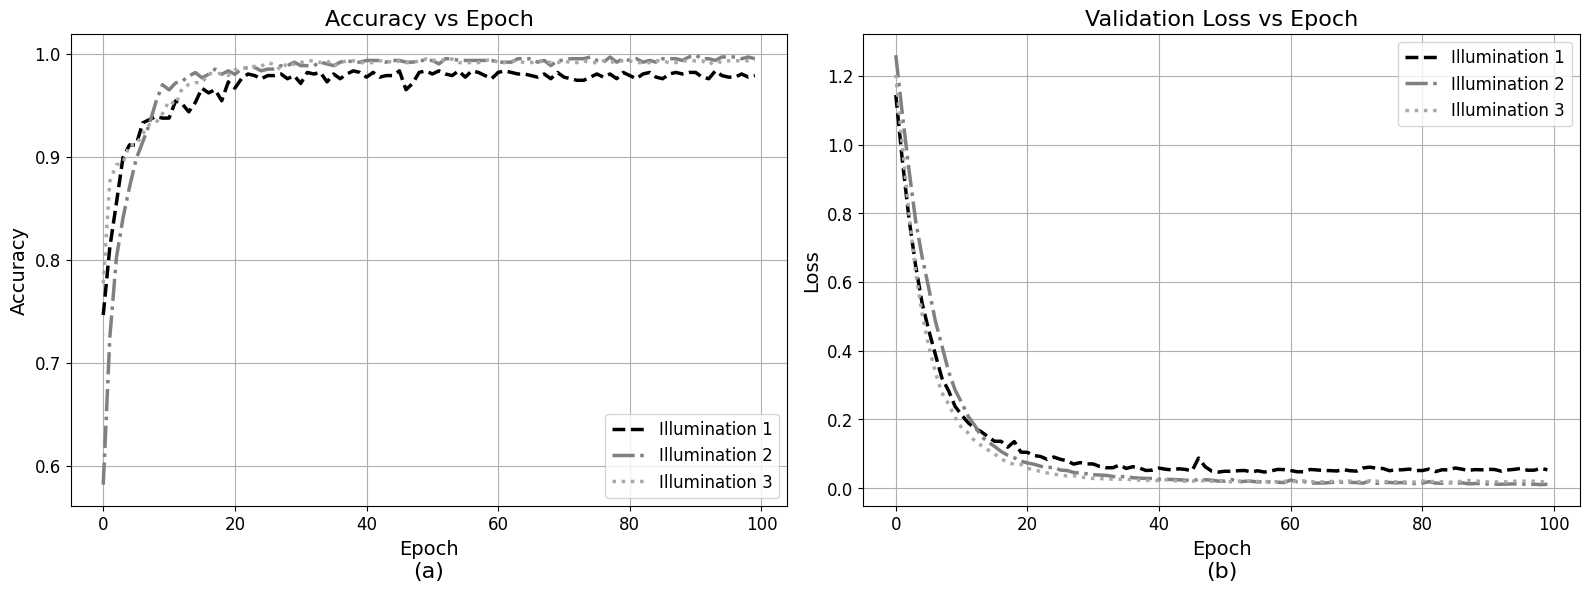

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tamaño de fuente
fontsize_title = 16
fontsize_labels = 14
fontsize_ticks = 12
fontsize_legend = 12
fontsize_letter = 16  # Tamaño de fuente para las letras (a), (b), (c), (d)

# Grosor de la línea
line_width = 2.5  # Ajusta el grosor de la línea aquí

# Estilos de línea en blanco y negro
line_styles = ['--', '-.', ':', '-']  # Punteadas, líneas discontinuas, etc.
colors = ['black', 'gray', 'darkgray']  # Colores en escala de grises

# Graficar curvas de aprendizaje
plt.figure(figsize=(16, 6))

# Gráfico 1: Precisión de Entrenamiento
ax1 = plt.subplot(1, 2, 1)
ax1.plot(mobilenetv2_resultsM1["val_acc"], label='Illumination 1', linewidth=line_width, color=colors[0], linestyle=line_styles[0])
ax1.plot(mobilenetv2_resultsM2["val_acc"], label='Illumination 2', linewidth=line_width, color=colors[1], linestyle=line_styles[1])
ax1.plot(mobilenetv2_resultsM3["val_acc"], label='Illumination 3', linewidth=line_width, color=colors[2], linestyle=line_styles[2])
ax1.set_title('Accuracy vs Epoch', fontsize=fontsize_title)
ax1.set_xlabel('Epoch', fontsize=fontsize_labels)
ax1.set_ylabel('Accuracy', fontsize=fontsize_labels)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.legend(fontsize=fontsize_legend)
# Añadir la letra (a) debajo de la etiqueta del eje x
ax1.text(0.5, -0.15, '(a)', transform=ax1.transAxes, fontsize=fontsize_letter, ha='center')
ax1.grid(True)

# Gráfico 2: Pérdida de Validación
ax2 = plt.subplot(1, 2, 2)
ax2.plot(mobilenetv2_resultsM1["val_loss"], label='Illumination 1', linewidth=line_width, color=colors[0], linestyle=line_styles[0])
ax2.plot(mobilenetv2_resultsM2["val_loss"], label='Illumination 2', linewidth=line_width, color=colors[1], linestyle=line_styles[1])
ax2.plot(mobilenetv2_resultsM3["val_loss"], label='Illumination 3', linewidth=line_width, color=colors[2], linestyle=line_styles[2])
ax2.set_title('Validation Loss vs Epoch', fontsize=fontsize_title)
ax2.set_xlabel('Epoch', fontsize=fontsize_labels)
ax2.set_ylabel('Loss', fontsize=fontsize_labels)
ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax2.legend(fontsize=fontsize_legend)
ax2.text(0.5, -0.15, '(b)', transform=ax2.transAxes, fontsize=fontsize_letter, ha='center')
ax2.grid(True)

# Ajustar el espacio entre subgráficas
plt.tight_layout()
plt.show()


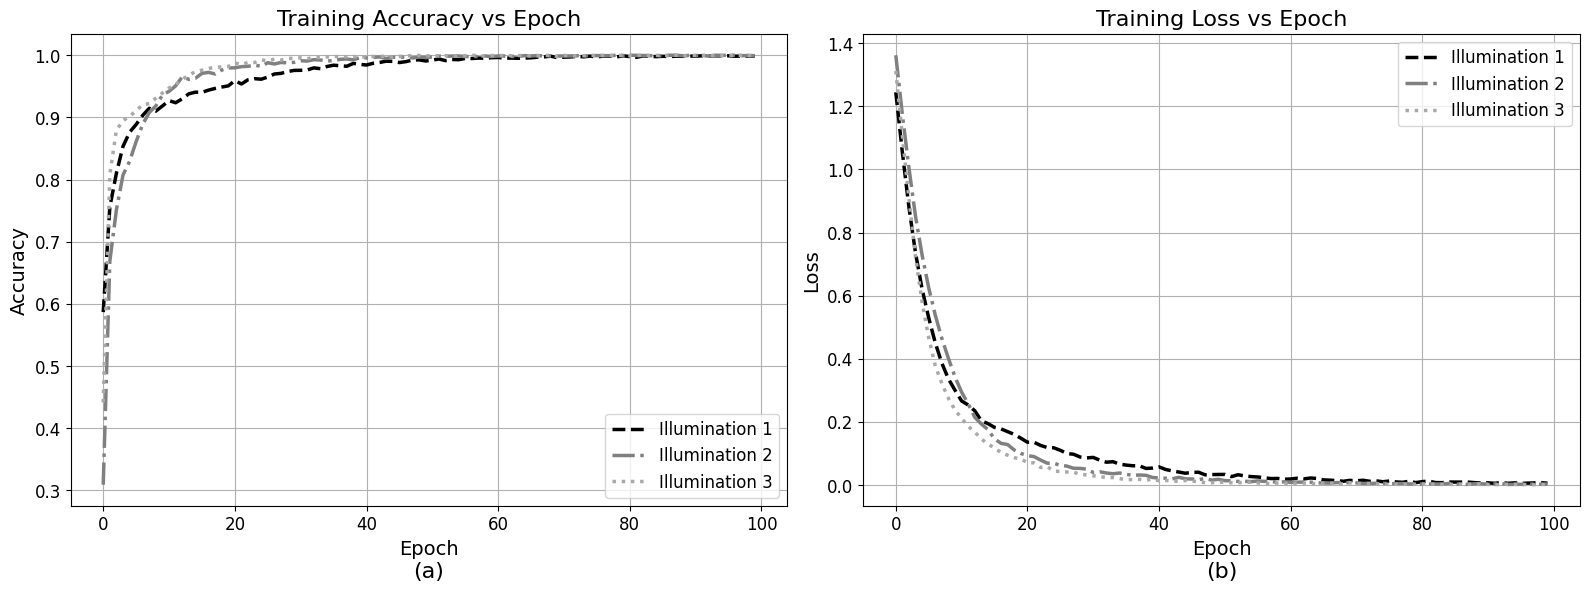

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tamaño de fuente
fontsize_title = 16
fontsize_labels = 14
fontsize_ticks = 12
fontsize_legend = 12
fontsize_letter = 16  # Tamaño de fuente para las letras (a), (b), (c), (d)

# Grosor de la línea
line_width = 2.5  # Ajusta el grosor de la línea aquí

# Estilos de línea en blanco y negro
line_styles = ['--', '-.', ':', '-']  # Punteadas, líneas discontinuas, etc.
colors = ['black', 'gray', 'darkgray']  # Colores en escala de grises

# Graficar curvas de aprendizaje
plt.figure(figsize=(16, 6))

# Gráfico 1: Precisión de Entrenamiento
ax1 = plt.subplot(1, 2, 1)
ax1.plot(mobilenetv2_resultsM1["train_acc"], label='Illumination 1', linewidth=line_width, color=colors[0], linestyle=line_styles[0])
ax1.plot(mobilenetv2_resultsM2["train_acc"], label='Illumination 2', linewidth=line_width, color=colors[1], linestyle=line_styles[1])
ax1.plot(mobilenetv2_resultsM3["train_acc"], label='Illumination 3', linewidth=line_width, color=colors[2], linestyle=line_styles[2])
ax1.set_title('Training Accuracy vs Epoch', fontsize=fontsize_title)
ax1.set_xlabel('Epoch', fontsize=fontsize_labels)
ax1.set_ylabel('Accuracy', fontsize=fontsize_labels)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.legend(fontsize=fontsize_legend)
# Añadir la letra (a) debajo de la etiqueta del eje x
ax1.text(0.5, -0.15, '(a)', transform=ax1.transAxes, fontsize=fontsize_letter, ha='center')
ax1.grid(True)

# Gráfico 2: Pérdida de Entrenamiento
ax2 = plt.subplot(1, 2, 2)
ax2.plot(mobilenetv2_resultsM1["train_loss"], label='Illumination 1', linewidth=line_width, color=colors[0], linestyle=line_styles[0])
ax2.plot(mobilenetv2_resultsM2["train_loss"], label='Illumination 2', linewidth=line_width, color=colors[1], linestyle=line_styles[1])
ax2.plot(mobilenetv2_resultsM3["train_loss"], label='Illumination 3', linewidth=line_width, color=colors[2], linestyle=line_styles[2])
ax2.set_title('Training Loss vs Epoch', fontsize=fontsize_title)
ax2.set_xlabel('Epoch', fontsize=fontsize_labels)
ax2.set_ylabel('Loss', fontsize=fontsize_labels)
ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax2.legend(fontsize=fontsize_legend)
ax2.text(0.5, -0.15, '(b)', transform=ax2.transAxes, fontsize=fontsize_letter, ha='center')
ax2.grid(True)
# Guardar la figura con 300 DPI
plt.savefig('learning.png', dpi=300)

# Ajustar el espacio entre subgráficas
plt.tight_layout()
plt.show()


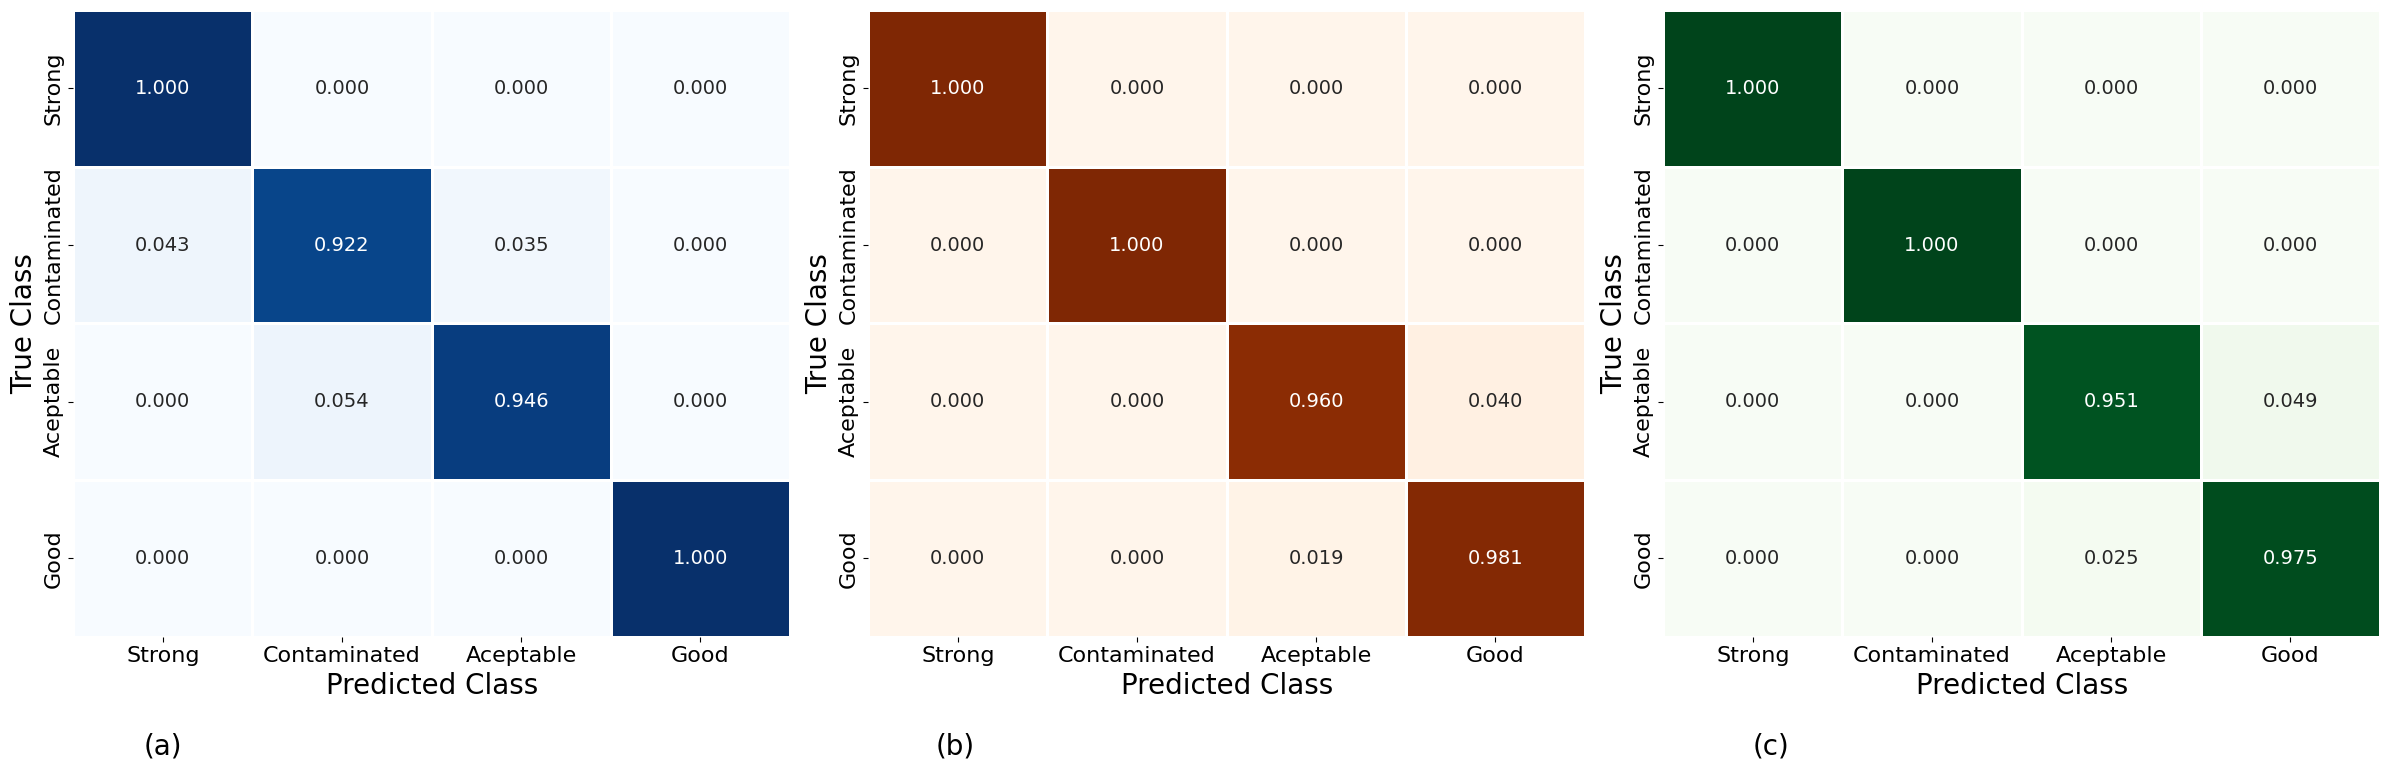

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Nombres de las clases
class_names = ["Strong", "Contaminated", "Aceptable", "Good"]

# Crear una figura con tres subgráficos
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Lista de resultados de los modelos
models = {
    "Illumination 1": (mobilenetv2_resultsM1["all_labels_val"], mobilenetv2_resultsM1["all_preds_val"]),
    "Illumination 2": (mobilenetv2_resultsM2["all_labels_val"], mobilenetv2_resultsM2["all_preds_val"]),
    "Illumination 3": (mobilenetv2_resultsM3["all_labels_val"], mobilenetv2_resultsM3["all_preds_val"]),
}

# Opciones de color
color_palettes = ["Blues", "Oranges", "Greens", "Purples", "Reds", "YlGnBu", "coolwarm"]

for ax, (model_name, (all_labels, all_preds)), palette in zip(axes, models.items(), color_palettes):
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_preds)
    norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    norm_conf_matrix[np.isnan(norm_conf_matrix)] = 0  # Reemplazar NaN con 0

    # Matriz de confusión normalizada
    sns.heatmap(norm_conf_matrix, annot=True, cmap=palette, fmt=".3f", cbar=False, ax=ax, 
                linewidths=1, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14})
    #ax.set_title(f'Normalized Confusion Matrix - {model_name}', fontsize=16)
    ax.set_xlabel('Predicted Class', fontsize=20)
    ax.set_ylabel('True Class', fontsize=20)
    ax.tick_params(axis='both', labelsize=16)

# Añadir distintivos debajo de los ejes x
fig.text(0.07, 0.05, '(a)', fontsize=20, ha='center')
fig.text(0.4, 0.05, '(b)', fontsize=20, ha='center')
fig.text(0.74, 0.05, '(c)', fontsize=20, ha='center')

# Ajustar los subplots para evitar superposición
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Ajustar la posición para hacer espacio para los distintivos

# Guardar la figura con 300 DPI
plt.savefig('Normalized_Confusion_Matrices.png', dpi=300)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Definir nombres de las clases (modifica según tus clases)
class_names = ["class1", "class2", "class3", "class4"]

# Resultados de cada modelo
models = {
    "MobileNetV2 M1": {
        "metrics": movilnetv2_val_metricsM1,
        "results": mobilenetv2_resultsM1
    },
    "MobileNetV2 M2": {
        "metrics": movilnetv2_val_metricsM2,
        "results": mobilenetv2_resultsM2
    },
    "MobileNetV2 M3": {
        "metrics": movilnetv2_val_metricsM3,
        "results": mobilenetv2_resultsM3
    },
}

# Inicializar lista para almacenar los resultados
results = []

# Calcular métricas para cada modelo
for model_name, data in models.items():
    metrics = data["metrics"]
    results_dict = data["results"]
    
    # Extraer las últimas métricas de entrenamiento y validación
    train_loss = results_dict["train_loss"][-1]
    train_acc = results_dict["train_acc"][-1]
    val_loss = results_dict["val_loss"][-1]
    val_acc = results_dict["val_acc"][-1]

    # Binarizar etiquetas para el cálculo de la curva ROC
    all_labels = np.array(results_dict["all_labels_val"])  # Convertir a array de NumPy si es necesario
    all_labels_bin = label_binarize(all_labels, classes=range(len(class_names)))

    # Convertir all_probs_val a un array de NumPy si es necesario
    all_probs = np.array(results_dict["all_probs_val"])

    # Calcular la curva ROC para la clase de interés
    fpr, tpr, _ = roc_curve(all_labels_bin[:, 1], all_probs[:, 1])  # Cambia el índice si deseas una clase específica
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.interp(mean_fpr, fpr, tpr)
    mean_auc = auc(mean_fpr, mean_tpr)

    # Agregar resultados a la lista
    results.append({
        "Model": model_name,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Overall AUC": mean_auc,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"],
        "F1-score": metrics["F1-score"]
    })

# Crear el DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar el DataFrame
print(results_df)

# Opcional: Guardar el DataFrame en un archivo CSV
results_df.to_csv('model_results_combined.csv', index=False)


            Model  Train Accuracy  Validation Accuracy  Train Loss  \
0  MobileNetV2 M1             1.0             0.992355    0.000169   
1  MobileNetV2 M2             1.0             1.000000    0.000049   
2  MobileNetV2 M3             1.0             1.000000    0.000026   

   Validation Loss  Overall AUC  Accuracy  Precision    Recall  F1-score  
0         0.022607     0.999297  0.992355   0.992361  0.992355   0.99235  
1         0.001182     1.000000  1.000000   1.000000  1.000000   1.00000  
2         0.001504     1.000000  1.000000   1.000000  1.000000   1.00000  


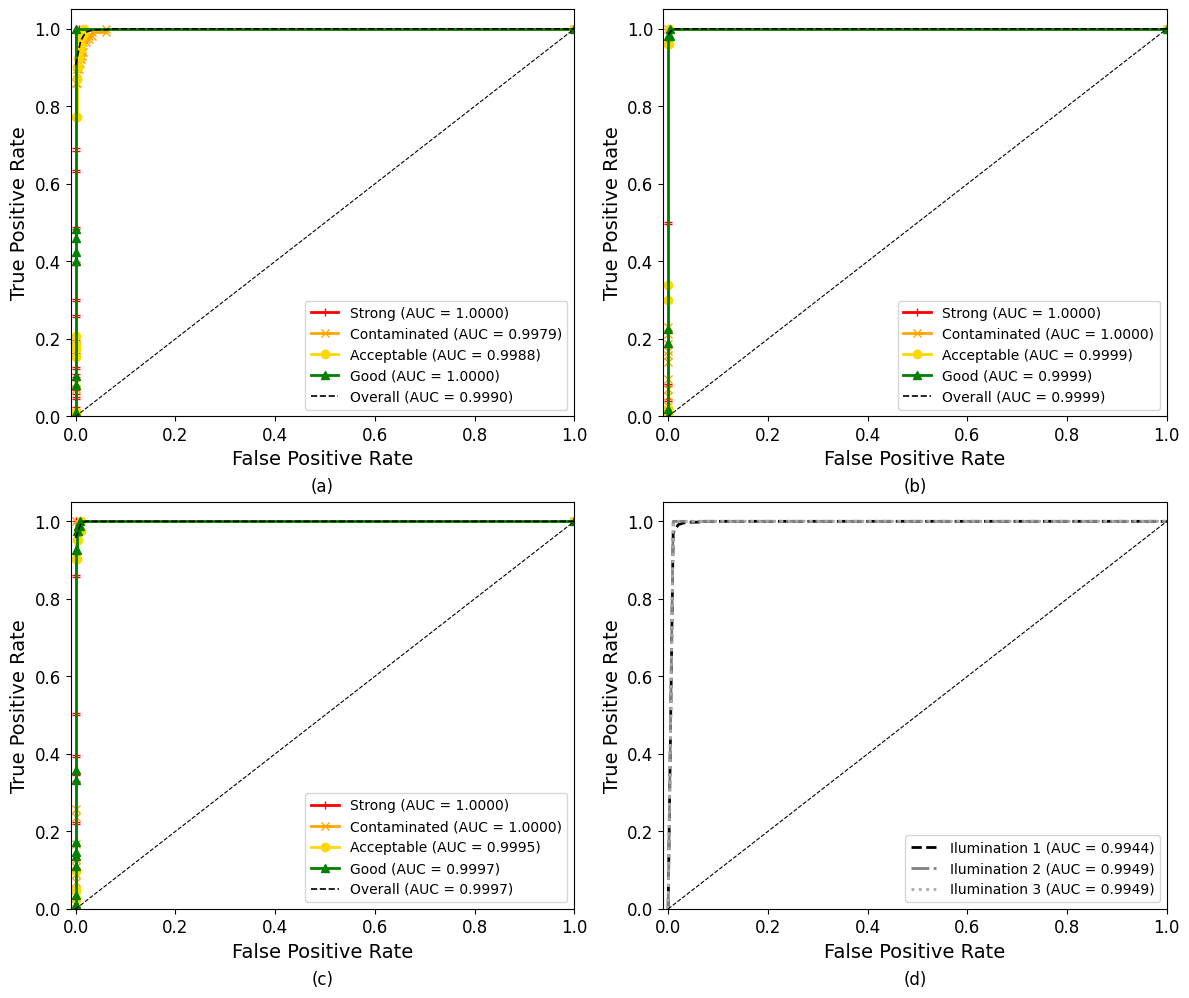

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Función para graficar curvas ROC
def plot_roc_curve(ax, all_probs, all_labels, model_name, class_names):
    # Binarizar las etiquetas
    all_labels_bin = label_binarize(all_labels, classes=range(len(class_names)))
    
    # Inicializar listas para curvas ROC
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # Calcular curvas ROC para cada clase
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Graficar curvas ROC para cada clase
    colors = ['red', 'orange', '#FFD700', 'green']
    markers = ['+', 'x', 'o', '^']
    for i in range(len(class_names)):
        ax.plot(fpr[i], tpr[i], color=colors[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})',
                linewidth=2, marker=markers[i])
    
    # Calcular y graficar la curva ROC promedio
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, 'k--', label=f'Overall (AUC = {mean_auc:.4f})', linewidth=1.2)
    
    # Líneas de referencia
    ax.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(loc='lower right')

# Crear figura y subplots en dos filas (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Cambié la disposición a 2 filas, 2 columnas
class_names = ["Strong", "Contaminated", "Acceptable", "Good"]

# Datos de probabilidades y etiquetas de los tres modelos
models_data = [
    (np.array(mobilenetv2_resultsM1.get("all_probs_val", [])), np.array(mobilenetv2_resultsM1.get("all_labels_val", [])), "Ilumination 1"),
    (np.array(mobilenetv2_resultsM2.get("all_probs_val", [])), np.array(mobilenetv2_resultsM2.get("all_labels_val", [])), "Ilumination 2"),
    (np.array(mobilenetv2_resultsM3.get("all_probs_val", [])), np.array(mobilenetv2_resultsM3.get("all_labels_val", [])), "Ilumination 3"),
]

# Graficar cada modelo en un subplot
for i, (all_probs, all_labels, model_name) in enumerate(models_data):
    row, col = divmod(i, 2)  # Aquí se calcula la fila y columna del subplot
    plot_roc_curve(axes[row, col], all_probs, all_labels, model_name, class_names)
    axes[row, col].text(0.5, -0.15, f"({chr(97 + i)})", ha="center", va="top", fontsize=12, transform=axes[row, col].transAxes)

# Graficar el ROC promedio general en el cuarto subplot
line_styles = ['--', '-.', ':', '-']  # Estilos de línea
bw_colors = ['black', 'gray', 'darkgray']  # Colores en escala de grises

for idx, (all_probs, all_labels, model_name) in enumerate(models_data):
    all_labels_bin = label_binarize(all_labels, classes=range(len(class_names)))
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for j in range(len(class_names)):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, j], all_probs[:, j])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(class_names)
    
    # Ajustar para que inicie en (0, 0)
    mean_tpr[0] = 0.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    axes[1, 1].plot(mean_fpr, mean_tpr, linestyle=line_styles[idx % len(line_styles)], color=bw_colors[idx % len(bw_colors)],
                    label=f'{model_name} (AUC = {mean_auc:.4f})', linewidth=2)
    
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=0.8)
axes[1, 1].set_xlim([-0.01, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate', fontsize=14)
axes[1, 1].set_ylabel('True Positive Rate', fontsize=14)
axes[1,1].tick_params(axis='both', labelsize=12)
axes[1, 1].legend(loc='lower right')
axes[1, 1].text(0.5, -0.15, "(d)", ha="center", va="top", fontsize=12, transform=axes[1, 1].transAxes)

# Guardar la figura con 300 DPI
plt.savefig('ROC.png', dpi=300)

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()
